*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 13: Parallelizing Neural Network Training with TensorFlow  (Part 2/2)


Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

## Building a neural network model in TensorFlow

### The TensorFlow Keras API (tf.keras)

### Building a linear regression model

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

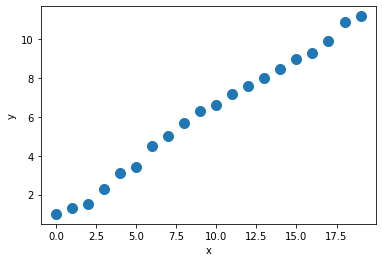

In [6]:
X_train = np.arange(20).reshape((20, 1))
y_train = np.array([1.0, 1.3, 1.5, 2.3, 3.1,
                    3.4, 4.5, 5.0, 5.7, 6.3,
                    6.6, 7.2, 7.6, 8.0, 8.5,
                    9.0, 9.3, 9.9, 10.9, 11.2])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [7]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

In [48]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b


model = Model()

model.build(input_shape=(None, 1))
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [20]:
## Mean squared error
def loss_fun(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## testing the function:
yt = tf.convert_to_tensor([1.0, 5.3, 5.8, 6.2])
yp = tf.convert_to_tensor([1.2, 4.2, 4.6, 6.1])

loss_fun(yt, yp)

<tf.Tensor: shape=(), dtype=float32, numpy=0.67500037>

In [49]:
## GRadient descent 

def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fun(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

In [33]:
steps_per_epoch

ds_train

<BatchDataset shapes: ((None, 1), (None,)), types: (tf.float32, tf.float32)>

In [50]:
tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))

ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fun(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

Epoch    0 Step  0 Loss 20.2500
Epoch    5 Step 100 Loss 3.3699
Epoch   10 Step 200 Loss 0.4869
Epoch   15 Step 300 Loss 13.7909
Epoch   20 Step 400 Loss 15.7436
Epoch   25 Step 500 Loss 10.4096
Epoch   30 Step 600 Loss 10.8084
Epoch   35 Step 700 Loss 0.5739
Epoch   40 Step 800 Loss 2.7224
Epoch   45 Step 900 Loss 1.7868
Epoch   50 Step 1000 Loss 1.1671
Epoch   55 Step 1100 Loss 0.9790
Epoch   60 Step 1200 Loss 0.6216
Epoch   65 Step 1300 Loss 0.0218
Epoch   70 Step 1400 Loss 0.0182
Epoch   75 Step 1500 Loss 0.1084
Epoch   80 Step 1600 Loss 0.0612
Epoch   85 Step 1700 Loss 0.3373
Epoch   90 Step 1800 Loss 0.0367
Epoch   95 Step 1900 Loss 0.0099
Epoch  100 Step 2000 Loss 0.2283
Epoch  105 Step 2100 Loss 0.0941
Epoch  110 Step 2200 Loss 0.1221
Epoch  115 Step 2300 Loss 0.0456
Epoch  120 Step 2400 Loss 0.0538
Epoch  125 Step 2500 Loss 0.1066
Epoch  130 Step 2600 Loss 0.0387
Epoch  135 Step 2700 Loss 0.0346
Epoch  140 Step 2800 Loss 0.0045
Epoch  145 Step 2900 Loss 0.0595
Epoch  150 Step 

Final Parameters: 3.1513522 6.11285


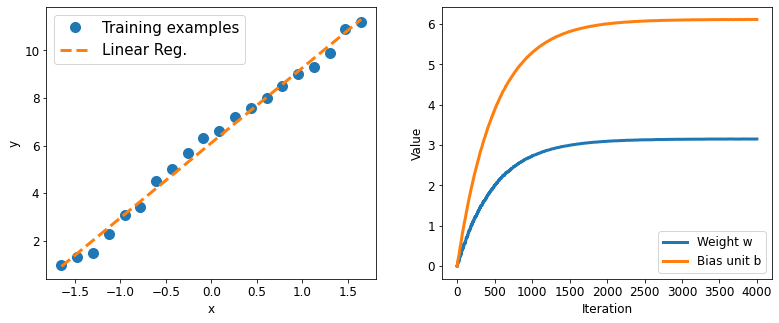

In [51]:
print('Final Parameters:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 19, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=12)
ax.set_ylabel('y', size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=12)
ax.set_xlabel('Iteration', size=12)
ax.set_ylabel('Value', size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

### Model training via the .compile() and .fit() methods

In [53]:
tf.random.set_seed(1)

model = Model()
#model.build((None, 1))

model.compile(optimizer='sgd', 
              loss=loss_fun,
              metrics=['mae', 'mse'])

In [54]:
model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size, verbose=1)

Epoch 1/200
20/20 [==============================] - 0s 4ms/step - loss: 33.8148 - mae: 5.1095 - mse: 33.8148
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 14.9880 - mae: 3.4199 - mse: 14.9880
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 6.6632 - mae: 2.2532 - mse: 6.6632
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 2.9873 - mae: 1.5134 - mse: 2.9873
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 1.3565 - mae: 1.0269 - mse: 1.3565
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6357 - mae: 0.6973 - mse: 0.6357
Epoch 7/200
20/20 [==============================] - 0s 2ms/step - loss: 0.3189 - mae: 0.4992 - mse: 0.3189
Epoch 8/200
20/20 [==============================] - 0s 2ms/step - loss: 0.1775 - mae: 0.3672 - mse: 0.1775
Epoch 9/200
20/20 [==============================] - 0s 2ms/step - loss: 0.1181 - mae: 0.2905 - mse: 0.1181
Epoch 10/200
20/20 [====

3.1503992 6.1201334


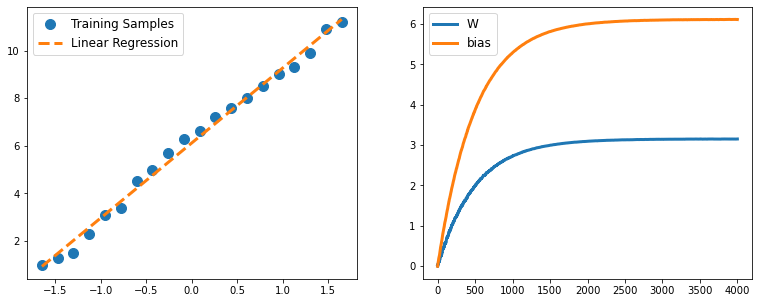

In [55]:
print(model.w.numpy(), model.b.numpy())

X_test = np.linspace(0, 19, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=12)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=12)
plt.show()

## Building a multilayer perceptron for classifying flowers in the Iris dataset

In [ ]:
import tensorflow_datasets as tfds

iris, iris_info = tfds.load('iris', with_info=True)

print(iris_info)

In [13]:
tf.random.set_seed(1)

ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)

print(next(iter(ds_orig)))

ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=2>}


In [15]:
## checking the number of examples:

n = 0
for i in ds_train_orig:
    n += 1
print(n)


n = 0
for i in ds_test:
    n += 1
print(n)

100
50


In [ ]:
ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

next(iter(ds_train_orig))

In [19]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(4, name='fc2', activation='softmax')])

iris_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 12)                60        
_________________________________________________________________
fc2 (Dense)                  (None, 4)                 52        
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________


In [20]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [22]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)


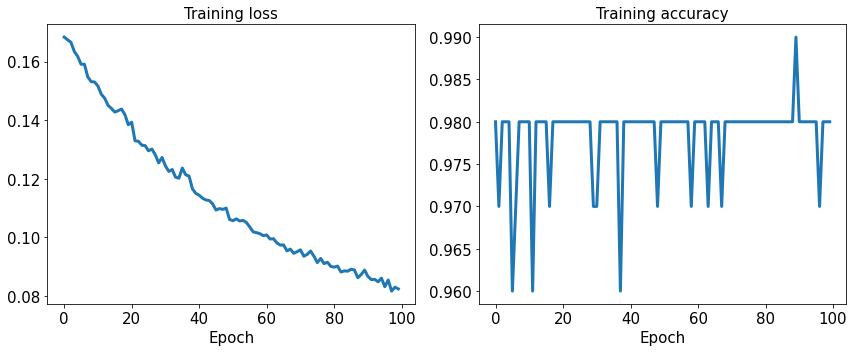

In [25]:
hist = history.history # tiene 'loss' and ' accuracy' parameters

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

plt.show()

### Evaluating the trained model on the test dataset

In [31]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.0800   Test Acc.: 0.9800


### Saving and reloading the trained model

In [23]:
iris_model.save('iris-classifier.h5', 
                overwrite=True,
                include_optimizer=True,
                save_format='h5')

In [24]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

iris_model_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

In [34]:
labels_train = []
for i, item in enumerate(ds_train_orig):
    labels_train.append(item[1].numpy())
    
labels_test = []
for i, item in enumerate(ds_test):
    labels_test.append(item[1].numpy())
    
print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))

Training Set:  100 Test Set:  50


In [27]:
iris_model_new.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "Dense", "config": {"name": "fc1", "trainable": true, "batch_input_shape": [null, 4], "dtype": "float32", "units": 16, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "fc2", "trainable": true, "dtype": "float32", "units": 3, "activation": "softmax", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}]}, "keras_version": "2.2.4-tf", "backend": "tensor

## Choosing activation functions for multilayer neural networks


### Logistic function recap

In [36]:
import numpy as np

X = np.array([1, 1.4, 2.5, 1.3, 1.5, 2.3, 3.1,
              3.4, 4.5, 5.0, 5.7, 6.3]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5, 0.6, 0.2, 0.6, 0.8,
              0.3, 0.3, 0.9, 0.59, 0.52])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)) 

P(y=1|x) = 1.000


In [44]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4, 1.3],
              [0.2, 0.4, 1.0, 0.2, 3.3],
              [0.6, 1.5, 1.2, 0.7, 0.3],
              [0.8, 3.5, 1.7, 0.4, 2.4]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6, 0.4]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)

print('Net Input: \n', Z)

print('Output Units:\n', y_probas) 

Net Input: 
 [2.3  2.08 1.77 3.03]
Output Units:
 [0.90887704 0.88894403 0.85445767 0.95391117]


In [45]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label: %d' % y_class) 

Predicted class label: 3


### Estimating class probabilities in multiclass classification via the softmax function

In [46]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.22390377 0.17968698 0.13179087 0.46461837]


1.0

In [55]:
import tensorflow as tf

Z_tensor = tf.expand_dims(Z, axis=0)
sm =tf.keras.activations.softmax(Z_tensor)
sm[0].numpy()

print('Probabilities:\n', sm[0].numpy())

np.sum(sm[0].numpy())

Probabilities:
 [0.22390377 0.17968698 0.13179087 0.46461837]


1.0

### Broadening the output spectrum using a hyperbolic tangent

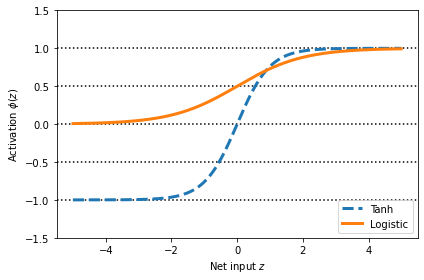

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [57]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [58]:
# import tensorflow as tf

tf.keras.activations.tanh(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])>

In [59]:
# Logistic Function

from scipy.special import expit

expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [60]:
# Logistic Function

tf.keras.activations.sigmoid(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])>

### Rectified linear unit activation

In [61]:
# import tensorflow as tf

tf.keras.activations.relu(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=array([0.   , 0.   , 0.   , ..., 4.985, 4.99 , 4.995])>

## Summary

# Appendix

## Splitting a dataset: danger of mixing train/test examples

In [65]:
## the correct way:

ds = tf.data.Dataset.range(10)
ds = ds.shuffle(10, reshuffle_each_iteration=False)

ds_train = ds.take(7)
ds_test = ds.skip(7)

ds_train = ds_train.shuffle(7).repeat(10)
ds_test = ds_test.shuffle(3)
ds_test = ds_test.repeat(10)

set_train = set()
for i,item in enumerate(ds_train):
    set_train.add(item.numpy())

set_test = set()
for i,item in enumerate(ds_test):
    set_test.add(item.numpy())

print(set_train, set_test)

{0, 2, 3, 4, 6, 8, 9} {1, 5, 7}


In [68]:
## The wrong way:

ds = tf.data.Dataset.range(10)
ds = ds.shuffle(10, reshuffle_each_iteration=True)

ds_train = ds.take(7)
ds_test = ds.skip(7)

ds_train = ds_train.shuffle(7).repeat(10)
ds_test = ds_test.shuffle(3)
ds_test = ds_test.repeat(10)

set_train = set()
for i,item in enumerate(ds_train):
    set_train.add(item.numpy())

set_test = set()
for i,item in enumerate(ds_test):
    set_test.add(item.numpy())

print(set_train, set_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


### Splitting a dataset using `tfds.Split`

In [85]:

##--------------------------- Attention ------------------------##
##                                                              ##
##     Note: currently, tfds.Split has a bug  in TF 2.0.0       ##
##                                                              ##
##  I.e., splitting [2, 1] is expected to result in             ##
##      100 train and 50 test examples                          ##
##                                                              ##
##  but instead, it results in 116 train and 34 test examples   ##
##                                                              ##
##--------------------------------------------------------------##

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

##  method 1: specifying percentage:
#first_67_percent = tfds.Split.TRAIN.subsplit(tfds.percent[:67])
#last_33_percent = tfds.Split.TRAIN.subsplit(tfds.percent[-33:])

#ds_train_orig = tfds.load('iris', split=first_67_percent)
#ds_test = tfds.load('iris', split=last_33_percent)


##  method 2: specifying the weights

ds_train_orig = tfds.load('iris', split='train[0:100]')
ds_test = tfds.load('iris', split='train[100:150]')

print(next(iter(ds_train_orig)))
print()
print(next(iter(ds_test)))

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([5.1, 3.4, 1.5, 0.2], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.3, 3.4, 5.6, 2.4], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=2>}


<br>
<br>
<br>

In [84]:
ds_train_orig = ds_train_orig.shuffle(100, reshuffle_each_iteration=True)
ds_test  = ds_test.shuffle(50, reshuffle_each_iteration=False)

ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

print(next(iter(ds_train_orig)))


for j in range(5):
    labels_train = []
    for i,item in enumerate(ds_train_orig):
        labels_train.append(item[1].numpy())

    labels_test = []
    for i,item in enumerate(ds_test):
        labels_test.append(item[1].numpy())
    print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))

    labels_test = np.array(labels_test)

    print(np.sum(labels_test == 0), np.sum(labels_test == 1), np.sum(labels_test == 2))

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([5.8, 2.7, 5.1, 1.9], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
Training Set:  99 Test Set:  50
15 16 19
Training Set:  99 Test Set:  50
15 16 19
Training Set:  99 Test Set:  50
15 16 19
Training Set:  99 Test Set:  50
15 16 19
Training Set:  99 Test Set:  50
15 16 19


---

Readers may ignore the next cell.

In [42]:
! python ../.convert_notebook_to_script.py --input ch13_part2.ipynb --output ch13_part2.py

[NbConvertApp] Converting notebook ch13_part2.ipynb to script
[NbConvertApp] Writing 14023 bytes to ch13_part2.py
